In [ ]:
# General dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import time
from datetime import datetime, date, timedelta

# For Twitter API extraction
import tweepy
#!pip install python-dotenv
#from dotenv import load_dotenv

# Tweet pre-processor
#import preprocessor as p

# NLTK
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# TextBlob
from textblob import TextBlob



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:

import tweepy


# Authenticate with Twitter API
consumer_key = '' # insert twitter api consumer key here
consumer_secret = ''  # insert twitter api consumer_secret key here
access_token = ''  # insert twitter api access_token key here
access_token_secret = ''  # insert twitter api access_token_secret key here

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# Search for tweets containing specific keywords
tweets = tweepy.Cursor(api.search, 
                      q='covid-19 vaccine', 
                      lang='en', 
                      tweet_mode='extended').items(1000)

# Create a list to store the tweets
tweet_list = []

# Iterate over the tweets and store them in the list
for tweet in tweets:
    tweet_list.append({
        'created_at': tweet.created_at,
        'text': tweet.full_text,
        'user': tweet.user.screen_name,
        'location': tweet.user.location
    })

In [ ]:
# Create a dataframe from the list of tweets
tweet_df = pd.DataFrame(tweet_list)

# View the dataframe
print(tweet_df)

In [ ]:
tweet_df.tail()

In [ ]:
# Save the dataframe to csv file
tweet_df.to_csv('tweets_updated.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tweets_df1 = pd.read_csv("/content/drive/MyDrive/P2/topic_v1.csv")
#tweets_df = tweets_df.dropna()
#tweets_df = tweets_df.reset_index()

In [ ]:
tweets_df = tweets_df1[['text','date','user_country','Tweets','Dominant_Topic','Perc_Dominant_Topic']]

**Topic Aspect**

The generated topics topic modeling are given below:

In [ ]:

# [(0, '0.020*"kid" + 0.018*"trial" + 0.016*"efficacy" + 0.014*"available" + 0.013*"decision" + 0.012*"recognise" + 0.012*"say" + 0.011*"datum" + 0.010*"include" + 0.010*"enter"'),

#  (1, '0.035*"vaccinate" + 0.033*"vaccine" + 0.032*"today" + 0.030*"covaxin" + 0.029*"take" + 0.027*"finally" + 0.024*"people" + 0.018*"thank" + 0.017*"fully" + 0.017*"administer"'),

#  (2, '0.333*"slot" + 0.245*"age" + 0.162*"dose" + 0.115*"date" + 0.058*"fee" + 0.024*"sep" + 0.006*"hospital" + 0.003*"sunny" + 0.003*"jul" + 0.002*"miracle"'), 
 
#  (3, '0.298*"dose" + 0.229*"free" + 0.228*"availability" + 0.132*"pay" + 0.005*"government" + 0.004*"group" + 0.003*"health" + 0.002*"city" + 0.002*"consider" + 0.002*"high"'),

#  (4, '0.080*"approve" + 0.070*"vaccine" + 0.059*"use" + 0.056*"approval" + 0.049*"emergency" + 0.032*"list" + 0.025*"child" + 0.024*"year" + 0.021*"covid" + 0.016*"say"')]

In [ ]:
def categorise(row):  
    if row['Dominant_Topic'] == 'Topic 0':
        return 'Clinical Trials'
    elif row['Dominant_Topic'] == 'Topic 1':
        return 'Administration Coverage'
    elif row['Dominant_Topic'] == 'Topic 2':
        return 'Slot Distribution'
    elif row['Dominant_Topic'] == 'Topic 3':
        return 'Dose Availability'
    elif row['Dominant_Topic'] == 'Topic 4':
        return 'Usage Approval'
    return ''

In [ ]:
#assignin the dominent topic with aspect on the basis of keyword in the topic

tweets_df['Dominant_Topic_rev'] = tweets_df.apply(lambda row: categorise(row), axis=1)
tweets_df =tweets_df[tweets_df['Dominant_Topic_rev'] != '']

In [ ]:
tweets_df.rename(columns = {'Tweets':'text_cleaned'}, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


# Sentiment Analysis

In [ ]:
# Define function to get value counts
def get_value_counts(col_name, analyzer_name):
    count = pd.DataFrame(tweets_df[col_name].value_counts())
    percentage = pd.DataFrame(tweets_df[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['sentiment', 'counts', 'percentage']
    value_counts_df.sort_values('sentiment', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
    value_counts_df['analyzer'] = analyzer_name
    return value_counts_df

**Vader**

In [ ]:
tweets_df['text_cleaned'] = tweets_df['text_cleaned'].astype(str)

<ipython-input-19-fc05607a96f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['text_cleaned'] = tweets_df['text_cleaned'].astype(str)


In [ ]:
sia = SentimentIntensityAnalyzer()
# Obtaining NLTK scores
tweets_df['nltk_scores'] = tweets_df['text_cleaned'].apply(lambda x: sia.polarity_scores(x))

# Obtaining NLTK compound score
tweets_df['nltk_cmp_score'] = tweets_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

<ipython-input-20-c77abfbe6166>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['nltk_scores'] = tweets_df['text_cleaned'].apply(lambda x: sia.polarity_scores(x))
<ipython-input-20-c77abfbe6166>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['nltk_cmp_score'] = tweets_df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])


In [ ]:
tweets_df.head()

,text,date,user_country,text_cleaned,Dominant_Topic,Perc_Dominant_Topic,nltk_scores,nltk_cmp_score
0,The agency also released new information for h...,12/12/2020 17:45,India,release new information health care provider p...,Topic 1,0.80,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.4939
1,The US Food and Drug Administration (FDA) has ...,12/12/2020 14:58,India,emergency authorization mrna,Topic 4,0.80,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.3818
2,I’ve never been so excited to get a vaccine 💉💉...,12/14/2020 23:48,India,excited,Topic 0,0.60,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3400
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,12/14/2020 20:00,India,save world,Topic 0,0.73,"{'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'comp...",0.4939
4,Toronto to receive Ontario's 1st doses of Pfiz...,12/14/2020 18:27,India,covid vaccine today,Topic 1,0.51,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [ ]:
neutral_thresh = 0.05

In [ ]:
# Categorize scores into the sentiments of positive, neutral or negative
tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

# Neutral score = 0
# tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c > 0 else ('Negative' if c < 0 else 'Neutral'))

<ipython-input-23-b7e7a98d7229>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['nltk_sentiment'] = tweets_df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


In [ ]:
tweets_df['nltk_cmp_score'].describe()


count    49920.000000
mean         0.109696
std          0.265768
min         -0.937100
25%          0.000000
50%          0.000000
75%          0.381800
max          0.969800
Name: nltk_cmp_score, dtype: float64

In [ ]:
nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
nltk_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,3956,7.92,NLTK Vader
1,Neutral,30605,61.31,NLTK Vader
2,Positive,15359,30.77,NLTK Vader


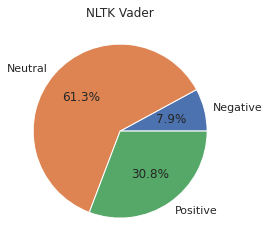

In [ ]:
sns.set_theme(style="white")
ax = plt.pie(nltk_sentiment_df['percentage'], labels=nltk_sentiment_df['sentiment'], autopct='%1.1f%%')
plt.title('NLTK Vader')
plt.show()

**TextBlob**

In [ ]:
# Obtain polarity scores generated by TextBlob
tweets_df['textblob_score'] = tweets_df['text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

<ipython-input-29-b22fc0c26e1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['textblob_score'] = tweets_df['text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
neutral_thresh = 0.05

In [ ]:
# Convert polarity score into sentiment categories
tweets_df['textblob_sentiment'] = tweets_df['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))


In [ ]:
tweets_df['textblob_score'].describe()


count    49920.000000
mean         0.089173
std          0.203127
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.100000
max          1.000000
Name: textblob_score, dtype: float64

In [ ]:
textblob_sentiment_df = get_value_counts('textblob_sentiment','TextBlob')
textblob_sentiment_df

,sentiment,counts,percentage,analyzer
0,Negative,1915,3.84,TextBlob
1,Neutral,34832,69.78,TextBlob
2,Positive,13173,26.39,TextBlob


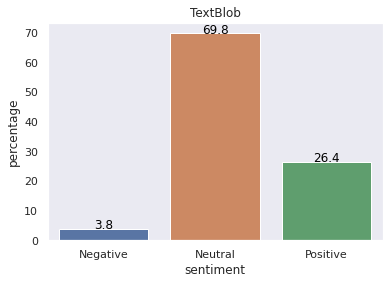

In [ ]:
sns.set_theme(style="dark")
ax = sns.barplot(x="sentiment", y="percentage", data=textblob_sentiment_df)
ax.set_title('TextBlob')

for index, row in textblob_sentiment_df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

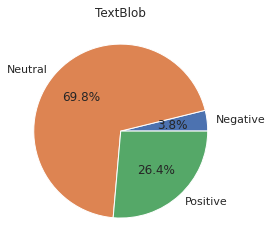

In [ ]:
sns.set_theme(style="dark")
ax = plt.pie(textblob_sentiment_df['percentage'], labels=textblob_sentiment_df['sentiment'], autopct='%1.1f%%')
plt.title('TextBlob')
plt.show()

Insights from Sentiment Analyses

In [ ]:
df_sentiments = pd.concat([nltk_sentiment_df, 
                           textblob_sentiment_df, 
                           #stanza_sentiment_df,
                           #flair_sentiment_df,
                           #corenlp_sentiment_df,
                          ]).reset_index(drop=True)
df_sentiments

,sentiment,counts,percentage,analyzer
0,Negative,3956,7.92,NLTK Vader
1,Neutral,30605,61.31,NLTK Vader
2,Positive,15359,30.77,NLTK Vader
3,Negative,1915,3.84,TextBlob
4,Neutral,34832,69.78,TextBlob
5,Positive,13173,26.39,TextBlob


In [ ]:
df_sentiments_pivot = df_sentiments.pivot(index='sentiment', columns='analyzer', values='percentage')
df_sentiments_pivot

analyzer,NLTK Vader,TextBlob
sentiment,,
Negative,7.92,3.84
Neutral,61.31,69.78
Positive,30.77,26.39


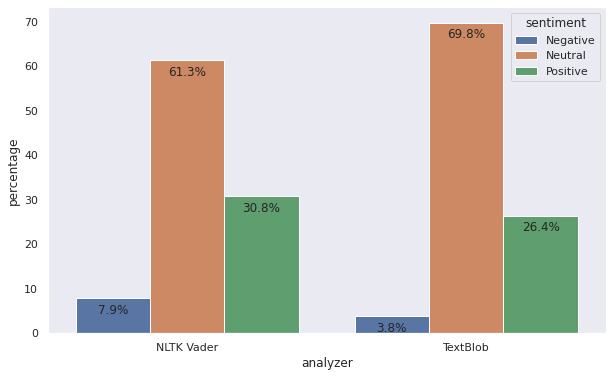

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="analyzer", y="percentage",
                 hue="sentiment", data=df_sentiments)

# Display annotations
for p in ax.patches:
    ax.annotate(f"{round(p.get_height(),1)}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [ ]:
df_sentiments

,sentiment,counts,percentage,analyzer
0,Negative,3956,7.92,NLTK Vader
1,Neutral,30605,61.31,NLTK Vader
2,Positive,15359,30.77,NLTK Vader
3,Negative,1915,3.84,TextBlob
4,Neutral,34832,69.78,TextBlob
5,Positive,13173,26.39,TextBlob


In [ ]:
tweets_df

,text,date,user_country,text_cleaned,Dominant_Topic,Perc_Dominant_Topic,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,Dominant_Topic_rev
0,The agency also released new information for h...,12/12/2020 17:45,India,release new information health care provider p...,Topic 1,0.80,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.4939,Positive,0.136364,Positive,Administration Coverage
1,The US Food and Drug Administration (FDA) has ...,12/12/2020 14:58,India,emergency authorization mrna,Topic 4,0.80,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.3818,Negative,0.000000,Neutral,Usage Approval
2,I’ve never been so excited to get a vaccine 💉💉...,12/14/2020 23:48,India,excited,Topic 0,0.60,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3400,Positive,0.375000,Positive,Clinical Trials
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,12/14/2020 20:00,India,save world,Topic 0,0.73,"{'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'comp...",0.4939,Positive,0.000000,Neutral,Clinical Trials
4,Toronto to receive Ontario's 1st doses of Pfiz...,12/14/2020 18:27,India,covid vaccine today,Topic 1,0.51,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.000000,Neutral,Administration Coverage
...,...,...,...,...,...,...,...,...,...,...,...,...
49858,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,11/17/2021 6:00,India,availability free slot pay slot dose,Topic 3,0.65,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability
49859,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,11/17/2021 5:30,India,availability free slot dose dose,Topic 3,0.57,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'comp...",0.5106,Positive,0.400000,Positive,Dose Availability
49860,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,11/17/2021 5:30,India,availability free slot pay slot dose,Topic 3,0.65,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability
49861,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,11/17/2021 5:00,India,availability free slot pay slot dose,Topic 3,0.57,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability


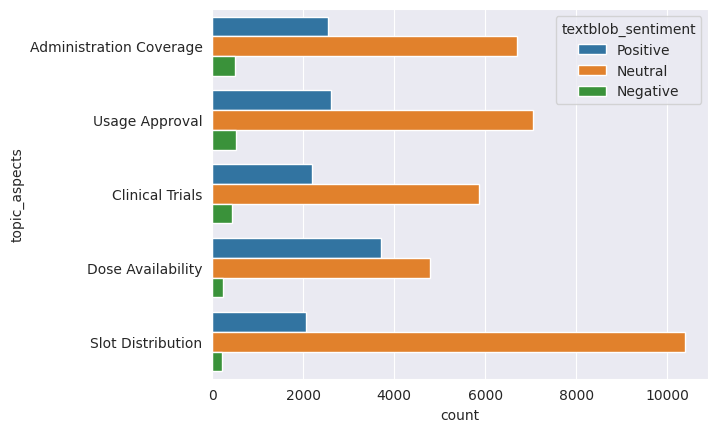

In [ ]:
sns.set_style("darkgrid")
sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = tweets_data)

In [ ]:
tweets_df.rename(columns = {'Dominant_Topic_rev':'topic_aspect'}, inplace = True)


# EDA

In [ ]:
tweets_df.to_csv("/content/drive/MyDrive/P2/tweets_v10.csv", index=False)

In [ ]:
#dataset import
tweets_data = pd.read_csv("/content/drive/MyDrive/P2/tweets_v10.csv")

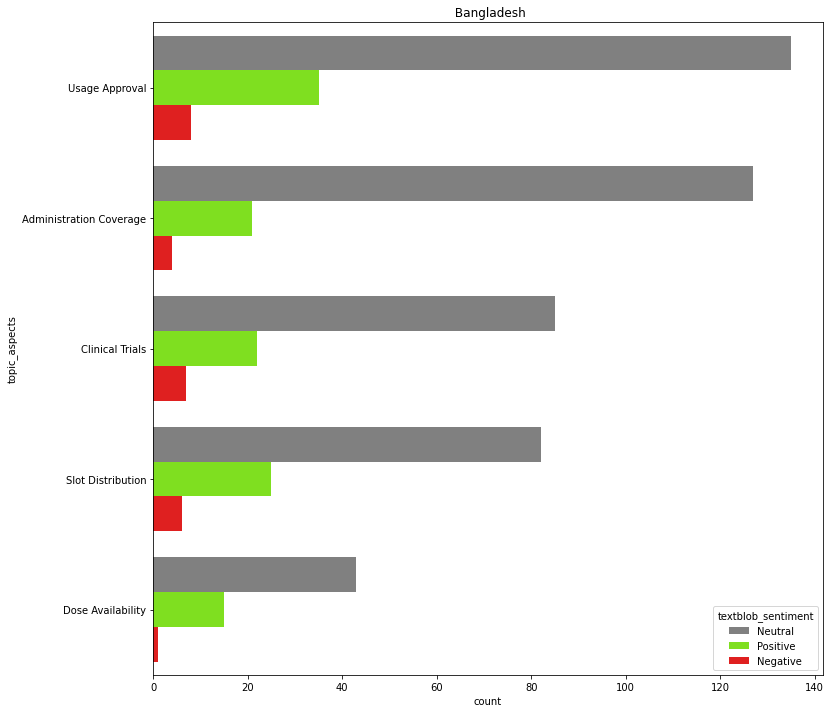

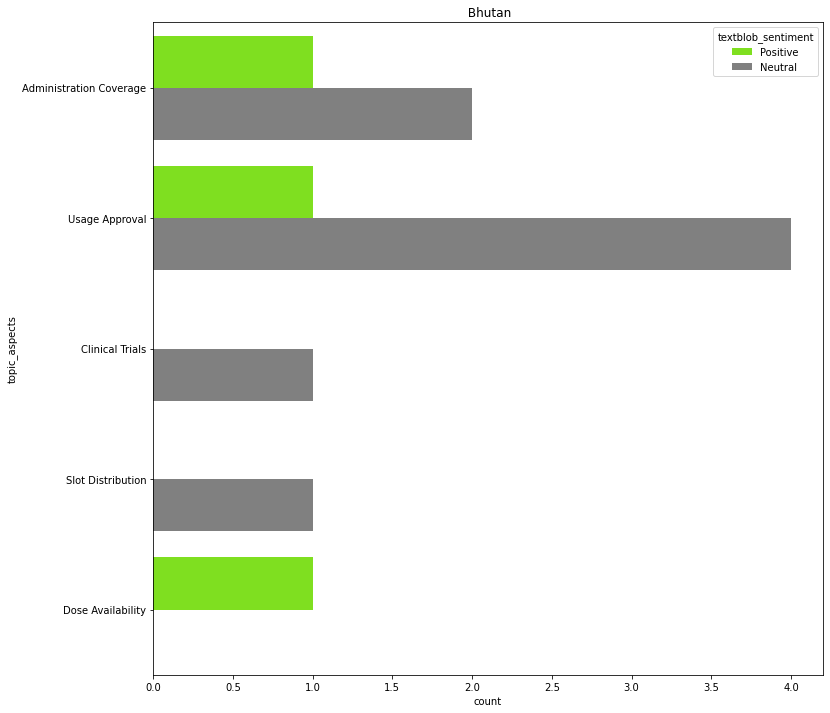

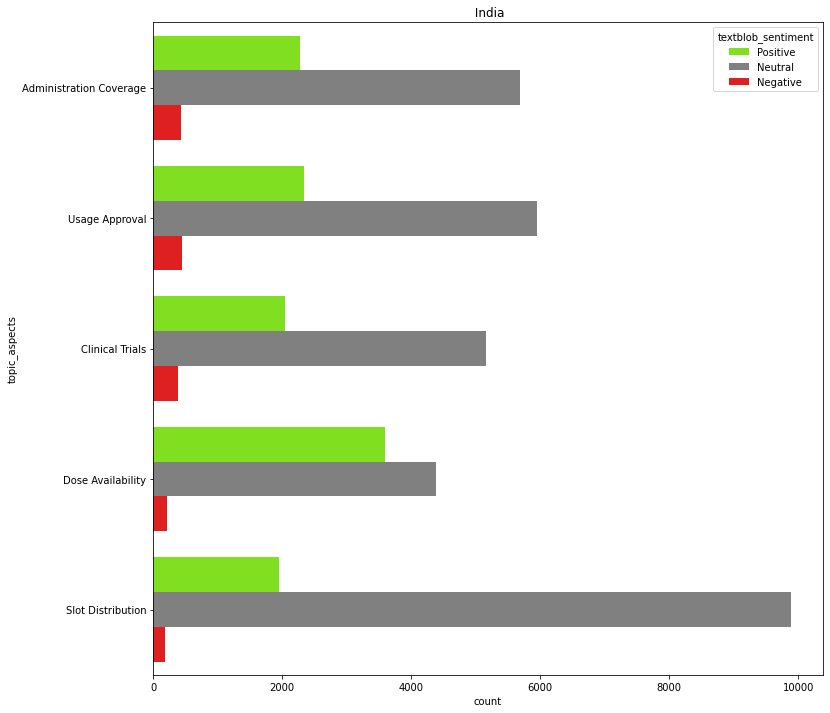

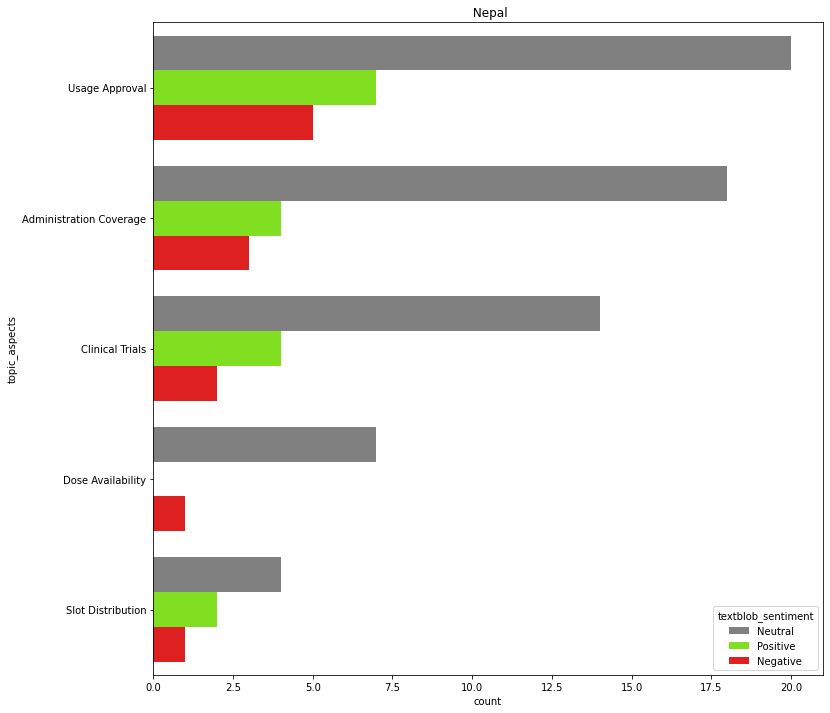

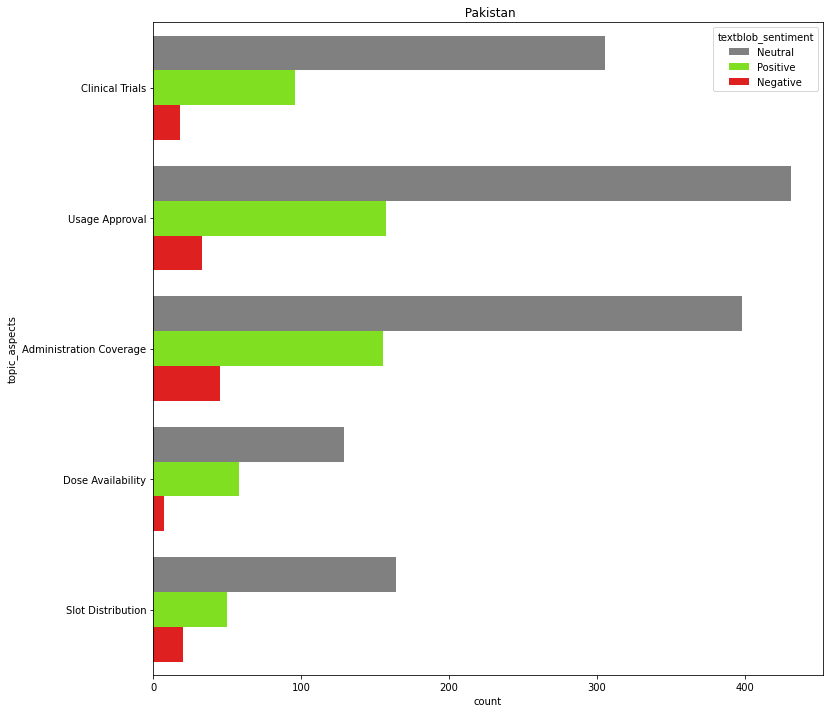

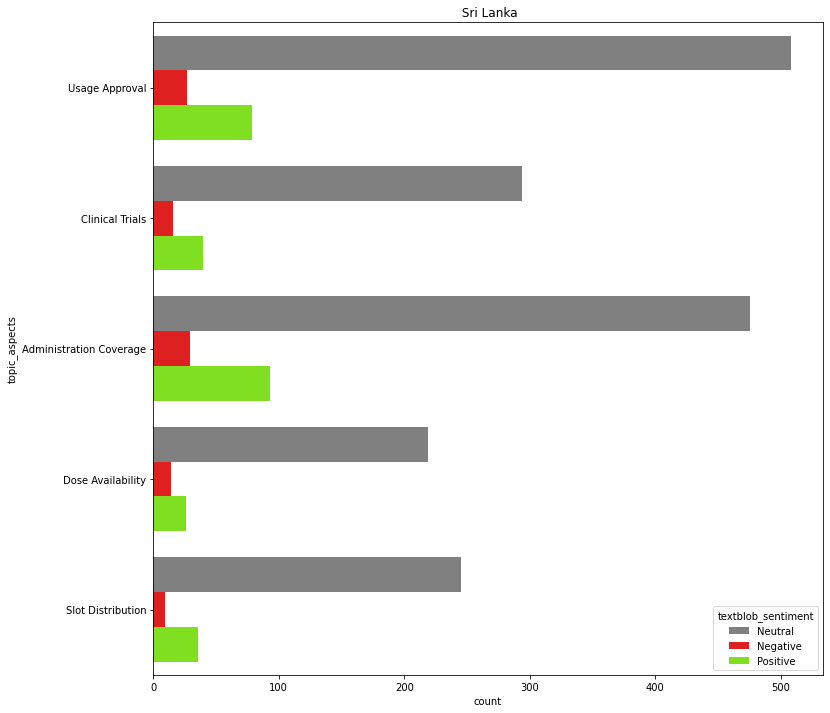

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors

# Group the data by the user_country column
grouped_data = tweets_data.groupby('user_country')

# Define a color palette for the textblob_sentiment column
#color_palette = {"Positive":"green", "Neutral":"blue", "Negative":"red"}
color_palette = {'Positive': mcolors.CSS4_COLORS['chartreuse'], 'Neutral': mcolors.CSS4_COLORS['gray'], 'Negative': mcolors.CSS4_COLORS['red']}

# Iterate over the grouped data and create a countplot for each country
for country, data in grouped_data:
    country_data = tweets_data.loc[data.index]
    plt.figure(figsize=(12,12))
    sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = country_data, palette = color_palette)
    plt.title(f' {country}')
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the data by the user_country column
grouped_data = tweets_data.groupby('user_country')

# Define a color palette for the textblob_sentiment column
color_palette = {"Positive":"green", "Neutral":"gray", "Negative":"red"}

# Get the number of countries
n = len(grouped_data)

# Create a figure with n subplots
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(30, 30))

# Flatten the array of axes
axes = axes.flatten()

# Iterate over the grouped data and create a countplot for each country
for i, (country, data) in enumerate(grouped_data):
    country_data = tweets_data.loc[data.index]
    sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = country_data, palette = color_palette, ax=axes[i])
    axes[i].set_title(f'Distribution of topic_aspects by textblob_sentiment for {country}')

plt.show()


In [ ]:
tweets_data.head()

,text,date,user_country,text_cleaned,Dominant_Topic,Perc_Dominant_Topic,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,topic_aspects
0,The agency also released new information for h...,12/12/2020 17:45,India,release new information health care provider p...,Topic 1,0.80,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.4939,Positive,0.136364,Positive,Administration Coverage
1,The US Food and Drug Administration (FDA) has ...,12/12/2020 14:58,India,emergency authorization mrna,Topic 4,0.80,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.3818,Negative,0.000000,Neutral,Usage Approval
2,I’ve never been so excited to get a vaccine 💉💉...,12/14/2020 23:48,India,excited,Topic 0,0.60,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3400,Positive,0.375000,Positive,Clinical Trials
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,12/14/2020 20:00,India,save world,Topic 0,0.73,"{'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'comp...",0.4939,Positive,0.000000,Neutral,Clinical Trials
4,Toronto to receive Ontario's 1st doses of Pfiz...,12/14/2020 18:27,India,covid vaccine today,Topic 1,0.51,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.000000,Neutral,Administration Coverage


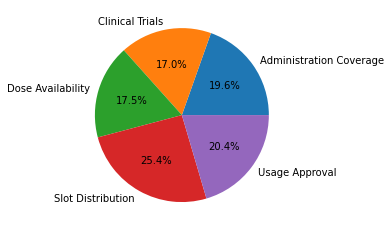

In [ ]:
import matplotlib.pyplot as plt

# Group the data by topic_aspects and count the number of occurrences of each aspect
grouped_data = tweets_data.groupby('topic_aspects').size()

# Create a pie chart
plt.pie(grouped_data, labels = grouped_data.index,autopct='%1.1f%%')
#plt.title("Topic Aspects Distribution")
plt.show()


In [ ]:
import pandas as pd

# Group the tweets_data dataset by user_country and textblob_sentiment columns
grouped_data = tweets_data.groupby(['user_country','textblob_sentiment']).size().reset_index(name='counts')

# Calculate the percentage of each sentiment for each user_country
grouped_data['percentage'] = grouped_data.groupby(['user_country'])['counts'].apply(lambda x: x/x.sum()*100)

# Pivot the dataframe to create a new dataframe with user_country as rows and textblob_sentiment as columns
df = grouped_data.pivot(index='user_country', columns='textblob_sentiment', values='percentage')

# Reset the index to make user_country a column
df.reset_index(inplace=True)

print(df)


textblob_sentiment user_country   Negative    Neutral   Positive
0                    Bangladesh   4.220779  76.623377  19.155844
1                        Bhutan        NaN  72.727273  27.272727
2                         India   3.691746  69.167910  27.140344
3                         Nepal  13.043478  68.478261  18.478261
4                      Pakistan   5.953533  69.070668  24.975799
5                     Sri Lanka   4.502370  82.511848  12.985782


In [ ]:
df.head()

textblob_sentiment,user_country,Negative,Neutral,Positive
0,Bangladesh,4.220779,76.623377,19.155844
1,Bhutan,NaN,72.727273,27.272727
2,India,3.691746,69.167910,27.140344
3,Nepal,13.043478,68.478261,18.478261
4,Pakistan,5.953533,69.070668,24.975799


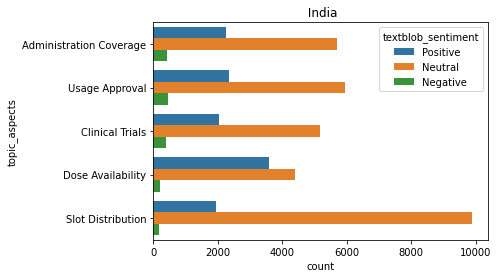

In [ ]:
import seaborn as sns

# Filter the data to only include rows where user_country is India
india_data = tweets_data[tweets_data['user_country'] == 'India']

# Create a countplot of the topic_aspects column
sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = india_data)
plt.title(' India')
plt.show()


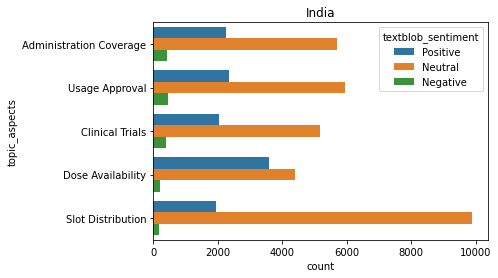

In [ ]:
import seaborn as sns

# Filter the data to only include rows where user_country is India
india_data = tweets_data[tweets_data['user_country'] == 'India']

# Create a countplot of the topic_aspects column
sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = india_data)
plt.title('India')
plt.show()

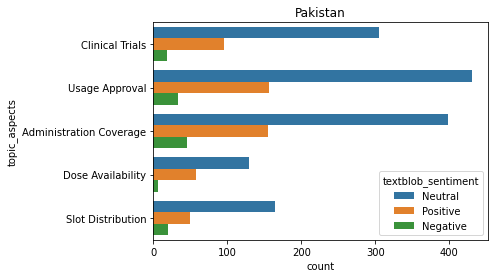

In [ ]:
import seaborn as sns

# Filter the data to only include rows where user_country is India
india_data = tweets_data[tweets_data['user_country'] == 'Pakistan']

# Create a countplot of the topic_aspects column
sns.countplot(y ='topic_aspects', hue = "textblob_sentiment", data = india_data)
plt.title('Pakistan')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from textblob import TextBlob

grouped_data = tweets_data.groupby(['user_country','textblob_sentiment']).size().reset_index(name='counts')

grouped_data['percentage'] = grouped_data.groupby(['user_country'])['counts'].apply(lambda x: x/x.sum()*100)

for i,country in enumerate(grouped_data.user_country.unique()):
    country_data = grouped_data[grouped_data.user_country == country]
    plt.figure(i)
    plt.pie(country_data['counts'], labels=country_data['textblob_sentiment'],autopct='%1.1f%%')
    plt.title(country)
plt.show()

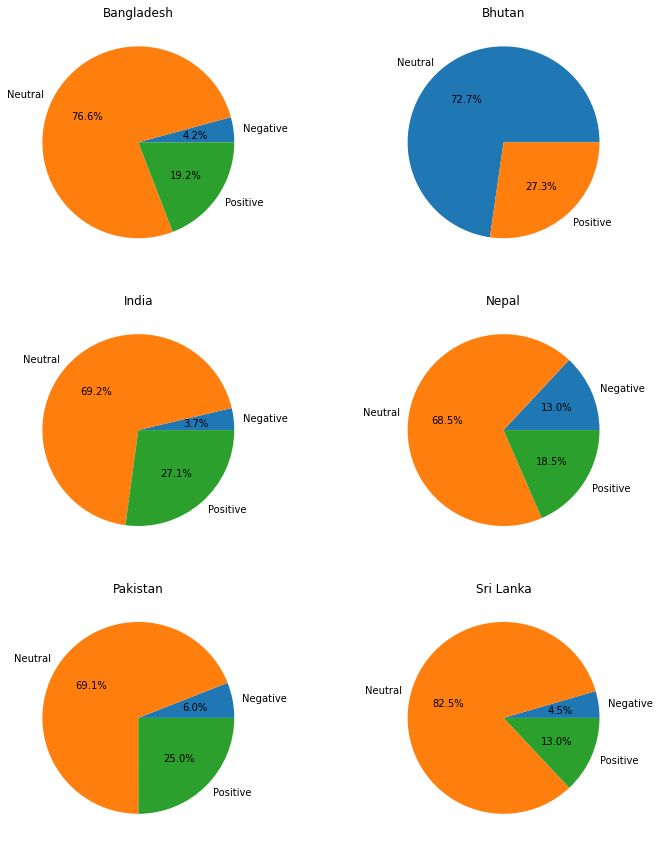

<Figure size 432x288 with 0 Axes>

In [ ]:
# First, import the necessary libraries
import matplotlib.pyplot as plt

# Create a figure with 2 columns and ceil(n/2) rows of subplots
n = len(grouped_data.user_country.unique())
figure, axs = plt.subplots(nrows=int(n/2)+n%2, ncols=2, figsize=(12, 5*int(n/2)+5*n%2))
axs = axs.ravel()

for i,country in enumerate(grouped_data.user_country.unique()):
    country_data = grouped_data[grouped_data.user_country == country]
    axs[i].pie(country_data['counts'], labels=country_data['textblob_sentiment'],autopct='%1.1f%%')
    axs[i].set_title(country)

plt.show()



In [ ]:
plt.savefig('piechart.png')

<Figure size 432x288 with 0 Axes>

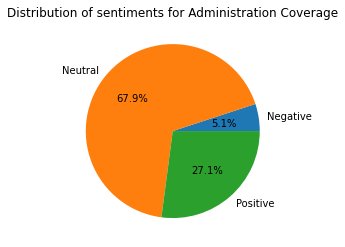

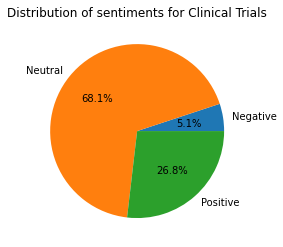

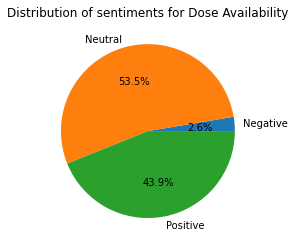

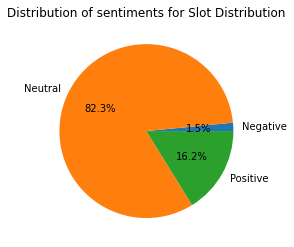

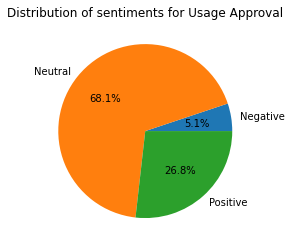

In [ ]:
india_data_topic = india_data.groupby(["topic_aspects","textblob_sentiment"]).size().reset_index(name="Count")
india_data_topic['proportion'] = india_data_topic.groupby("topic_aspects")["Count"].apply(lambda x: x / x.sum())

for topic in india_data_topic['topic_aspects'].unique():
    topic_data = india_data_topic[india_data_topic['topic_aspects'] == topic]
    plt.pie(topic_data['proportion'], labels = topic_data['textblob_sentiment'], autopct='%1.1f%%')
    plt.title(f'Distribution of sentiments for {topic}')
    plt.show()

In [ ]:
tweets_df

,text,date,user_country,text_cleaned,Dominant_Topic,Perc_Dominant_Topic,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,topic_aspects
0,The agency also released new information for h...,12/12/2020 17:45,India,release new information health care provider p...,Topic 1,0.80,"{'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'comp...",0.4939,Positive,0.136364,Positive,Administration Coverage
1,The US Food and Drug Administration (FDA) has ...,12/12/2020 14:58,India,emergency authorization mrna,Topic 4,0.80,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.3818,Negative,0.000000,Neutral,Usage Approval
2,I’ve never been so excited to get a vaccine 💉💉...,12/14/2020 23:48,India,excited,Topic 0,0.60,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.3400,Positive,0.375000,Positive,Clinical Trials
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,12/14/2020 20:00,India,save world,Topic 0,0.73,"{'neg': 0.0, 'neu': 0.238, 'pos': 0.762, 'comp...",0.4939,Positive,0.000000,Neutral,Clinical Trials
4,Toronto to receive Ontario's 1st doses of Pfiz...,12/14/2020 18:27,India,covid vaccine today,Topic 1,0.51,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.000000,Neutral,Administration Coverage
...,...,...,...,...,...,...,...,...,...,...,...,...
49858,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,11/17/2021 6:00,India,availability free slot pay slot dose,Topic 3,0.65,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability
49859,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,11/17/2021 5:30,India,availability free slot dose dose,Topic 3,0.57,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'comp...",0.5106,Positive,0.400000,Positive,Dose Availability
49860,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,11/17/2021 5:30,India,availability free slot pay slot dose,Topic 3,0.65,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability
49861,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,11/17/2021 5:00,India,availability free slot pay slot dose,Topic 3,0.57,"{'neg': 0.161, 'neu': 0.46, 'pos': 0.379, 'com...",0.4404,Positive,0.400000,Positive,Dose Availability


# Model

Vader

In [ ]:
tweets_data = tweets_df[['text','text_cleaned','nltk_cmp_score','nltk_sentiment','textblob_score','textblob_sentiment','Dominant_Topic_rev']]

In [ ]:
tweets_data

,text,text_nlp,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,Dominant_Topic_rev
0,The agency also released new information for h...,release new information health care provider p...,0.4939,Positive,0.136364,Positive,Administration Coverage
1,The US Food and Drug Administration (FDA) has ...,emergency authorization mrna,-0.3818,Negative,0.000000,Neutral,Usage Approval
2,I’ve never been so excited to get a vaccine 💉💉...,excited,0.3400,Positive,0.375000,Positive,Clinical Trials
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,save world,0.4939,Positive,0.000000,Neutral,Clinical Trials
4,Toronto to receive Ontario's 1st doses of Pfiz...,covid vaccine today,0.0000,Neutral,0.000000,Neutral,Administration Coverage
...,...,...,...,...,...,...,...
49858,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability
49859,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,availability free slot dose dose,0.5106,Positive,0.400000,Positive,Dose Availability
49860,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability
49861,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability


In [ ]:
tweets_data.rename(columns = {'text_cleaned':'text_nlp'}, inplace = True)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
#initialising dataset on which trianing is based
X = tweets_data.text_nlp # get all the text in x variable
y = tweets_data.nltk_sentiment # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y

(49807,)
(49807,)


In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [ ]:
#  import TF-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))
#transforming data to vector form to feed as input to the models
vect.fit(X_train) # fit or traing data tweets to vect
X_train_tm = vect.transform(X_train) # transform our training data tweets
X_test_tm = vect.transform(X_test)# transform our testing data tweets

In [ ]:
# Oversample imbalanced dataset with SMOTE
from collections import Counter
counter = Counter(y_train)
print("Imbalanced data:",counter)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train_tm, y_train.ravel())
counter = Counter(y_train_res)
print("Balanced data:",counter)

Imbalanced data: Counter({'Neutral': 24475, 'Positive': 12249, 'Negative': 3121})
Balanced data: Counter({'Neutral': 24475, 'Negative': 24475, 'Positive': 24475})


In [ ]:
#Import modules to calculate accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_res, y_train_res)
pred_lr = lr.predict(X_test_tm)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy = accuracy_score(y_test, pred_lr)
print("LR: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,pred_lr))
print(confusion_matrix(y_test,pred_lr))

LR: Test Accuracy: 94.46%
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83       835
     Neutral       0.94      0.98      0.96      6073
    Positive       0.98      0.90      0.94      3054

    accuracy                           0.94      9962
   macro avg       0.92      0.90      0.91      9962
weighted avg       0.95      0.94      0.94      9962

[[ 681  127   27]
 [  73 5971   29]
 [  54  242 2758]]


In [ ]:
from matplotlib import style
style.use('ggplot')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

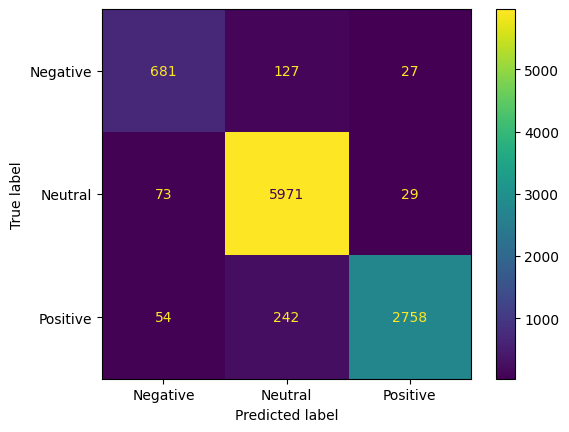

In [ ]:
style.use('default')
cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
disp.plot()

**Random Forest**

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier # import Random forest from sklearn
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier()

In [ ]:
rf_pred = rf.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, rf_pred)
print("RF: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test,rf_pred))

RF: Test Accuracy: 93.03%
              precision    recall  f1-score   support

    Negative       0.92      0.68      0.78       835
     Neutral       0.91      0.99      0.95      6073
    Positive       0.98      0.87      0.92      3054

    accuracy                           0.93      9962
   macro avg       0.94      0.85      0.89      9962
weighted avg       0.93      0.93      0.93      9962

[[ 571  235   29]
 [  15 6042   16]
 [  35  364 2655]]


**Naive Bayes**



In [ ]:
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
nb = MultinomialNB(alpha = 10) # get object of Multinomial naive bayes model with alpha parameter = 10
nb.fit(X_train_res, y_train_res)# fit our both traing data tweets as well as its sentiments to the multinomial naive bayes mod
y_pred_nb = nb.predict(X_test_tm) # predict the sentiments of testing data tweets

In [ ]:
accuracy = accuracy_score(y_test, y_pred_nb)
print("NB: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_nb))
print(confusion_matrix(y_test,y_pred_nb))

NB: Test Accuracy: 80.76%
              precision    recall  f1-score   support

    Negative       0.35      0.93      0.51       835
     Neutral       0.94      0.79      0.86      6073
    Positive       0.94      0.80      0.86      3054

    accuracy                           0.81      9962
   macro avg       0.74      0.84      0.74      9962
weighted avg       0.89      0.81      0.83      9962

[[ 774   44   17]
 [1100 4823  150]
 [ 344  262 2448]]


In [ ]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = nb, X = X_train_res, y = y_train_res, cv = 10) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean()

0.881703257137619

**Linear SVM**

In [ ]:
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
svm_clf = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [ ]:
svm_clf.fit(X_train_res, y_train_res)# fit our both traing data tweets as well as its sentiments to the SVC model
y_pred_svm = svm_clf.predict(X_test_tm)  # predict the sentiments of testing data tweets

accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

SVM: Test Accuracy: 96.15%
              precision    recall  f1-score   support

    Negative       0.93      0.82      0.87       835
     Neutral       0.96      0.99      0.97      6073
    Positive       0.98      0.94      0.96      3054

    accuracy                           0.96      9962
   macro avg       0.96      0.92      0.93      9962
weighted avg       0.96      0.96      0.96      9962

[[ 682  120   33]
 [  23 6023   27]
 [  29  152 2873]]


In [ ]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = svm_clf, X = X_train_tm, y = y_train, cv = 10)# do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.9446607194146723

**Decision Tree**


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(                                )
dt_pred = dt.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, dt_pred)
print("DT: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,dt_pred))
print(confusion_matrix(y_test,dt_pred))

DT: Test Accuracy: 94.59%
              precision    recall  f1-score   support

    Negative       0.88      0.75      0.81       835
     Neutral       0.94      0.99      0.96      6073
    Positive       0.98      0.91      0.94      3054

    accuracy                           0.95      9962
   macro avg       0.93      0.88      0.91      9962
weighted avg       0.95      0.95      0.94      9962

[[ 625  175   35]
 [  31 6013   29]
 [  53  216 2785]]


In [ ]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = dt, X = X_train_tm, y = y_train, cv = 10)# do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

0.9683524877426896

**Catboost**

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.8 MB/s eta 0:00:00


In [ ]:
import catboost as ctb
model_CBC = ctb.CatBoostClassifier()

In [ ]:
model_CBC.fit(X_train_res, y_train_res)

In [ ]:
y_pred_cb = model_CBC.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_cb)
print("catBoost: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_cb))
print(confusion_matrix(y_test,y_pred_cb))

# Modeling on TextBlob sentiment

In [ ]:
tweets_data

,text,text_nlp,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,Dominant_Topic_rev
0,The agency also released new information for h...,release new information health care provider p...,0.4939,Positive,0.136364,Positive,Administration Coverage
1,The US Food and Drug Administration (FDA) has ...,emergency authorization mrna,-0.3818,Negative,0.000000,Neutral,Usage Approval
2,I’ve never been so excited to get a vaccine 💉💉...,excited,0.3400,Positive,0.375000,Positive,Clinical Trials
3,#UgurSahin #ozlemtureci the #Muslim Scientists...,save world,0.4939,Positive,0.000000,Neutral,Clinical Trials
4,Toronto to receive Ontario's 1st doses of Pfiz...,covid vaccine today,0.0000,Neutral,0.000000,Neutral,Administration Coverage
...,...,...,...,...,...,...,...
49858,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability
49859,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,availability free slot dose dose,0.5106,Positive,0.400000,Positive,Dose Availability
49860,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability
49861,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,availability free slot pay slot dose,0.4404,Positive,0.400000,Positive,Dose Availability


In [ ]:
#initialising dataset on which trianing is based
X = tweets_data.text_nlp # get all the text in x variable
y = tweets_data.textblob_sentiment # get all the sentiments into y variable
print(X.shape) #print shape of x
print(y.shape) # print shape of y

(49807,)
(49807,)


In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split #from sklearn.cross_validation import train_test_split to split the data into training and tesing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 1) # split the data into traing and testing set where ratio is 80:20

In [ ]:
#  import TF-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
vect = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))
#transforming data to vector form to feed as input to the models
vect.fit(X_train) # fit or traing data tweets to vect
X_train_tm = vect.transform(X_train) # transform our training data tweets
X_test_tm = vect.transform(X_test)# transform our testing data tweets

In [ ]:
# Oversample imbalanced dataset with SMOTE
from collections import Counter
counter = Counter(y_train)
print("Imbalanced data:",counter)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train_tm, y_train.ravel())
counter = Counter(y_train_res)
print("Balanced data:",counter)

Imbalanced data: Counter({'Neutral': 27875, 'Positive': 10452, 'Negative': 1518})
Balanced data: Counter({'Neutral': 27875, 'Positive': 27875, 'Negative': 27875})


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_res, y_train_res)
pred_lr = lr.predict(X_test_tm)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy = accuracy_score(y_test, pred_lr)
print("LR: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,pred_lr))
print(confusion_matrix(y_test,pred_lr))

LR: Test Accuracy: 96.28%
              precision    recall  f1-score   support

    Negative       0.82      0.77      0.80       396
     Neutral       0.96      0.99      0.98      6901
    Positive       0.99      0.92      0.95      2665

    accuracy                           0.96      9962
   macro avg       0.92      0.89      0.91      9962
weighted avg       0.96      0.96      0.96      9962

[[ 305   80   11]
 [  40 6840   21]
 [  25  194 2446]]


In [ ]:
from matplotlib import style
style.use('ggplot')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

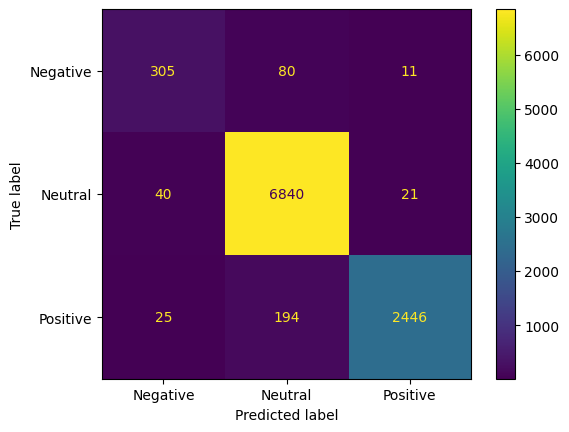

In [ ]:
style.use('default')
cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr.classes_)
disp.plot()

**Random Forest**

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier # import Random forest from sklearn
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train_res, y_train_res)

RandomForestClassifier()

In [ ]:
rf_pred = rf.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, rf_pred)
print("RF: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,rf_pred))
print(confusion_matrix(y_test,rf_pred))

RF: Test Accuracy: 94.30%
              precision    recall  f1-score   support

    Negative       0.90      0.53      0.66       396
     Neutral       0.93      1.00      0.96      6901
    Positive       0.99      0.87      0.92      2665

    accuracy                           0.94      9962
   macro avg       0.94      0.80      0.85      9962
weighted avg       0.94      0.94      0.94      9962

[[ 209  173   14]
 [  14 6872   15]
 [  10  342 2313]]


**Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB # import Multinomial Naive Bayes model from sklearn.naive_bayes
nb = MultinomialNB(alpha = 10) # get object of Multinomial naive bayes model with alpha parameter = 10
nb.fit(X_train_res, y_train_res)# fit our both traing data tweets as well as its sentiments to the multinomial naive bayes mod
y_pred_nb = nb.predict(X_test_tm) # predict the sentiments of testing data tweets

In [ ]:
accuracy = accuracy_score(y_test, y_pred_nb)
print("NB: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_nb))
print(confusion_matrix(y_test,y_pred_nb))

NB: Test Accuracy: 81.79%
              precision    recall  f1-score   support

    Negative       0.20      0.93      0.33       396
     Neutral       0.97      0.80      0.88      6901
    Positive       0.95      0.84      0.89      2665

    accuracy                           0.82      9962
   macro avg       0.70      0.86      0.70      9962
weighted avg       0.93      0.82      0.86      9962

[[ 370   18    8]
 [1251 5529  121]
 [ 242  174 2249]]


In [ ]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = nb, X = X_train_res, y = y_train_res, cv = 10) # do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean()

**Linear SVM**

In [ ]:
from sklearn.svm import LinearSVC # import SVC model from sklearn.svm
svm_clf = LinearSVC(random_state=0) # get object of SVC model with random_state parameter = 0

In [ ]:
svm_clf.fit(X_train_res, y_train_res)# fit our both traing data tweets as well as its sentiments to the SVC model
y_pred_svm = svm_clf.predict(X_test_tm)  # predict the sentiments of testing data tweets

accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_svm))
print(confusion_matrix(y_test,y_pred_svm))

SVM: Test Accuracy: 97.31%
              precision    recall  f1-score   support

    Negative       0.90      0.75      0.82       396
     Neutral       0.97      0.99      0.98      6901
    Positive       0.99      0.95      0.97      2665

    accuracy                           0.97      9962
   macro avg       0.95      0.90      0.92      9962
weighted avg       0.97      0.97      0.97      9962

[[ 298   85   13]
 [  23 6856   22]
 [  10  115 2540]]


In [ ]:
from sklearn.model_selection import cross_val_score  # import cross_val_score from sklear.model_selection
accuracies = cross_val_score(estimator = svm_clf, X = X_train_tm, y = y_train, cv = 10)# do K- fold cross validation on our traing data and its sentimenst with 10 fold cross validation
accuracies.mean() # measure the mean accuray of 10 fold cross validation

**Decision Tree**


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)
dt_pred = dt.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, dt_pred)
print("DT: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,dt_pred))
print(confusion_matrix(y_test,dt_pred))

DT: Test Accuracy: 96.03%
              precision    recall  f1-score   support

    Negative       0.82      0.70      0.76       396
     Neutral       0.96      0.99      0.97      6901
    Positive       0.99      0.92      0.95      2665

    accuracy                           0.96      9962
   macro avg       0.92      0.87      0.89      9962
weighted avg       0.96      0.96      0.96      9962

[[ 278  100   18]
 [  36 6848   17]
 [  23  201 2441]]


**Catboost**

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import catboost as ctb
model_CBC = ctb.CatBoostClassifier()

In [ ]:
model_CBC.fit(X_train_tm, y_train)

Learning rate set to 0.095487
0:	learn: 0.9806169	total: 2.67s	remaining: 44m 25s
1:	learn: 0.8915789	total: 4.93s	remaining: 40m 59s
2:	learn: 0.8152619	total: 6.93s	remaining: 38m 22s
3:	learn: 0.7547709	total: 9.18s	remaining: 38m 6s
4:	learn: 0.7068757	total: 11.4s	remaining: 37m 51s
5:	learn: 0.6637086	total: 13.7s	remaining: 37m 48s
6:	learn: 0.6285903	total: 15.6s	remaining: 36m 51s
7:	learn: 0.5968259	total: 17.8s	remaining: 36m 45s
8:	learn: 0.5694052	total: 20.4s	remaining: 37m 28s
9:	learn: 0.5459825	total: 22.8s	remaining: 37m 39s
10:	learn: 0.5250241	total: 25.6s	remaining: 38m 24s
11:	learn: 0.5067850	total: 28.1s	remaining: 38m 32s
12:	learn: 0.4910651	total: 31.1s	remaining: 39m 21s
13:	learn: 0.4768691	total: 33s	remaining: 38m 44s
14:	learn: 0.4633366	total: 35.3s	remaining: 38m 39s
15:	learn: 0.4523299	total: 37.6s	remaining: 38m 30s
16:	learn: 0.4425422	total: 39.3s	remaining: 37m 50s
17:	learn: 0.4322230	total: 40.7s	remaining: 37m 1s
18:	learn: 0.4230457	total: 42

In [ ]:
y_pred_cb = model_CBC.predict(X_test_tm)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_cb)
print("catBoost: Test Accuracy: {:.2f}%".format(accuracy * 100))
print(classification_report(y_test,y_pred_cb))
print(confusion_matrix(y_test,y_pred_cb))

catBoost: Test Accuracy: 96.31%
              precision    recall  f1-score   support

    Negative       0.91      0.60      0.73       396
     Neutral       0.96      0.99      0.98      6901
    Positive       0.99      0.93      0.96      2665

    accuracy                           0.96      9962
   macro avg       0.95      0.84      0.89      9962
weighted avg       0.96      0.96      0.96      9962

[[ 239  144   13]
 [  15 6864   22]
 [   9  165 2491]]
